# File d'attente

In [1]:
import random
from math import log
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from tqdm.notebook import trange, tqdm
from tools import PDF
pdf = PDF("img/1_ABC/")
import time
t = time.time()

### Générateur d'un loi exponentielle par méthode d'inversion

In [2]:
def exp_gen(lambda_, u=None):
    if u is None:
        u=random.random()
    return - log(1-u) / lambda_

### Simulation de la file d'attente

In [3]:
def file_attente(lambda1, lambda2, t, simplification=False, liste_dates_arrivée=None, liste_u=None):
    """
    liste_dates_arrivées et liste_u : seulement pour les méthodes v1 et v2
    """
    if liste_dates_arrivée is None:
        # On simule d'abord toutes les arrivées des clients
        liste_dates_arrivée = [exp_gen(lambda1)]
        temps_nouveau_client = exp_gen(lambda1)
        while liste_dates_arrivée[-1] + temps_nouveau_client <= t:
            liste_dates_arrivée.append(liste_dates_arrivée[-1] + temps_nouveau_client)
            temps_nouveau_client = exp_gen(lambda1)
    
    n_clients = len(liste_dates_arrivée)
    
    if liste_u is None:
        # On simule les temps de service de chaque client
        liste_temps_service = [exp_gen(lambda2) for _ in range(n_clients)]
    else:
        liste_temps_service = [exp_gen(lambda2, liste_u[i]) for i in range(n_clients)]
    
    # On calcule enfin les dates de début et de fin de service de chaque client
    num_client = 0
    date_arrivée = liste_dates_arrivée[num_client]
    temps_service = liste_temps_service[num_client]
    # Le premier client est servi dès son arrivée
    date_début_service = date_arrivée
    date_fin_service = date_début_service + temps_service
    
    liste_dates_début_service = [date_début_service]
    liste_dates_fin_service = [date_fin_service]    
    
    while num_client < n_clients-1:
        num_client += 1
        date_arrivée = liste_dates_arrivée[num_client]
        temps_service = liste_temps_service[num_client]
        
        if date_arrivée >= liste_dates_fin_service[-1]:
            # Si le client arrive après la fin de service du client précédent,
            # il est servi tout de suite
            date_début_service = date_arrivée            
            date_fin_service = date_début_service + temps_service
        else:
            # Sinon le client est servi à l'instant de la fin de service du client précédent
            date_début_service = liste_dates_fin_service[-1]
            date_fin_service = date_début_service + temps_service      

        liste_dates_début_service.append(date_début_service)
        liste_dates_fin_service.append(date_fin_service) 
        
        if simplification and date_fin_service > t:
            break

    l = len(liste_dates_début_service)
    if l < n_clients:
        liste_dates_début_service += [None for i in range(n_clients - l)]
        liste_dates_fin_service += [None for i in range(n_clients - l)]
        
    dico = {"Date arrivée client": liste_dates_arrivée, 
            "Date début service": liste_dates_début_service,
            "Temps service": liste_temps_service,
            "Date fin service": liste_dates_fin_service}
    
    return pd.DataFrame(dico)

## Approximate Bayesian Computation

Le problème que l'on essaye de résoudre désormais est d'estimer $\lambda_1$ et $\lambda_2$ en connaissant iniquement les dates de sortie des clients.

Le fonctionnement d'un algorithme ABC est de simuler, avec plusieurs distributions à priori des paramètres utilisés, les modèles liés à ses paramètres et d'observer les données simulées (ici ce sera les dates de sortie des clients). 

C'est à dire que nous allons simuler avec différents paramètres ($\lambda_1$, $\lambda_2$) tirés selon une distribution à priori la file d'attente, et observer les dates de fin de service des clients pour déterminer si ces dates correspondent, selon un critère que l'on choisira, aux dates initiales observées pour faire correspondre une distribution a posteriori des paramètres. On peut ensuite utiliser un critère de *best guess* comme la médiane pour estimer nos paramètres avec la distribution a posteriori.

On fait l'hypothèse raisonable que $(\lambda_1,\lambda_2)$ peut s'estimer uniquement par les date de fin de service en prenant une bonne mesure sans influence de $t$ dans cette estimation. On fixe arbitrairement $t = 10$.

La distance que l'on considère est celle de la norme 2, et on gardera un certain pourcentage des simulations les plus proches. Cette distance est légèrement modifiée pour garder une pertinence dans le cas où le nombre de clients servis est différent.

In [4]:
data = file_attente(2, 1, 10)
list(data["Date fin service"])

[1.094978618986015,
 3.8924810901088414,
 4.906333045389807,
 5.028812207364189,
 5.779329441604788,
 6.214977506375898,
 6.385230312468084,
 9.484576519031755,
 9.550054088540065,
 10.22386562504873,
 11.640281175725157,
 13.124031455198939,
 13.318427680502182,
 15.08693337149874]

In [5]:
def dist2mod(x,y):
    #L'idée est de faire commme si on considérait que pour le vecteur de plus petite taille on
    #répète la dernière composante pour avoir quelque chose à comparer.
    
    S = 0
    for i in range(max(len(x),len(y))):
        
        if i < len(x) and i < len(y):
            
            S += np.sqrt((x[i] - y[i])**2)
        else :
            #On fait la différence entre le rang actuel du non-limitant et le rang max pour le limitant
            if len(x) > len(y):
                
                #si y est limitant
                S += np.sqrt((x[i] - y[len(y)-1])**2)
            if len(x) < len(y):
                
                #si x est limitant
                S += np.sqrt((x[len(x)-1] - y[i])**2)
    return S

In [6]:
def ABC_evaluation(liste_observee, N = 100000, mu1 = 3, mu2 = 3):
    
    #Génération des distributions des lambdas
    L_lambda1 = [np.random.uniform(0,mu1) for i in range(N)]
    L_lambda2 = [np.random.uniform(0,mu2) for i in range(N)]
    
    #Liste des simulations sous forme de DataFrame et la liste des distances associées
    L_sim = []
    L_dist = []
    for i in trange(N):        
        #Simulation
        data = file_attente(L_lambda1[i], L_lambda2[i], 10)
        liste_dates = list(data["Date fin service"])
        #Ajout de la liste des dates dans L_Sim et de la distance dans L_dist
        L_sim.append(liste_dates)
        L_dist.append(dist2mod(liste_observee,liste_dates))
        
    df_simulations = pd.DataFrame({'Listes Dates': L_sim, 'Distance': L_dist, 'Lambda1': L_lambda1, 'Lambda2': L_lambda2})
    df_simulations.sort_values(by="Distance", inplace=True)
    return df_simulations

In [7]:
data = file_attente(2, 1, 10)
liste_observee = list(data["Date fin service"])

df_simulations = ABC_evaluation(liste_observee)
N = 100000
pourcentage = 0.0001
df_simulations_val = df_simulations.head(int(N * pourcentage))

  0%|          | 0/100000 [00:00<?, ?it/s]

In [8]:
df_simulations_val

,Listes Dates,Distance,Lambda1,Lambda2
61203,"[0.7321442266213685, 1.8105340087512665, 2.500...",17.649221,1.975929,0.591092
27716,"[1.020729209720324, 1.3584817603821633, 3.1245...",17.736648,1.935118,0.825779
92478,"[2.5666383041744822, 2.993089203915433, 3.5293...",18.039670,1.367724,0.595899
83674,"[0.841408269250967, 1.4594997582857836, 2.5534...",18.103206,2.156084,0.629177
13750,"[1.1941594554741402, 3.3926117747998497, 4.278...",18.356595,2.173854,0.860623
10924,"[1.2180639871943155, 2.519316347803166, 2.9534...",18.514144,2.063805,0.639986
33829,"[0.5450199846224719, 2.9716540226352226, 3.303...",18.712971,2.590761,0.998611
96291,"[0.5672396346469014, 1.6782435044233, 2.232271...",18.956986,1.678001,0.977109
82690,"[1.1679228633900969, 1.2363268739960571, 3.313...",18.998726,1.619124,0.829219
18063,"[1.5408939246019309, 2.321892071682166, 3.6563...",19.338219,2.598533,1.004099


In [9]:
print(df_simulations_val["Lambda1"].median())
print(df_simulations_val["Lambda2"].median())

2.019867340795906
0.8274990062440732


Il peut être interessant de s'interesser à une représentation en densité des résultats.

Export PDF : img/1_ABC/00.pdf



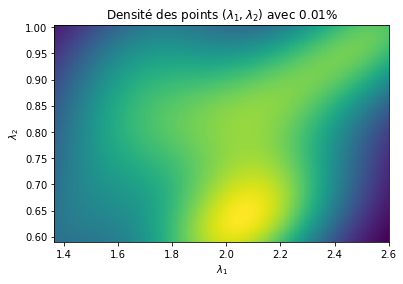

In [10]:
from scipy.stats import kde

def plot(df_simulations, pourcentage):
    N = len(df_simulations)
    df_simulations_val = df_simulations.head(int(N * pourcentage))

    x = df_simulations_val["Lambda1"]
    y = df_simulations_val["Lambda2"]

    nbins = 200
    k = kde.gaussian_kde([x,y])
    xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

    # Make the plot
    plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto')
    plt.xlabel("$\lambda_1$")
    plt.ylabel("$\lambda_2$")
    plt.title(f"Densité des points $(\lambda_1, \lambda_2)$ avec {pourcentage*100}%")
    pdf.export()
    plt.show()
    
plot(df_simulations, 0.0001)

Regardons avec d'autres paramètres si cela change significativement la distribution

Export PDF : img/1_ABC/01.pdf



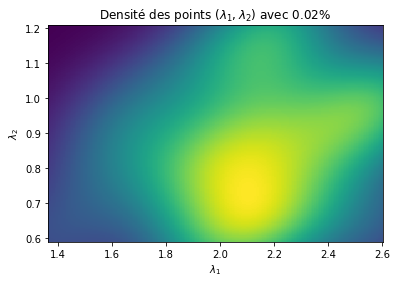

In [11]:
plot(df_simulations, 0.0002)

Export PDF : img/1_ABC/02.pdf



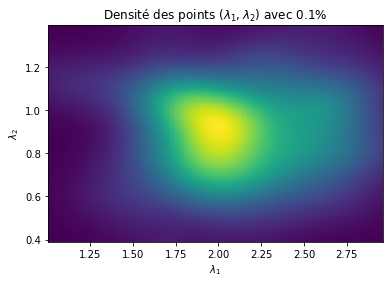

In [12]:
plot(df_simulations, 0.001)

Export PDF : img/1_ABC/03.pdf



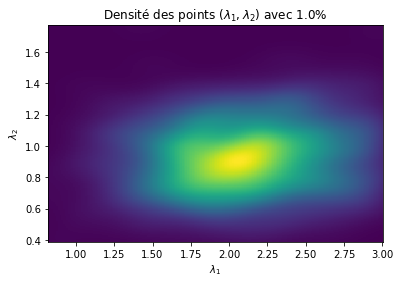

In [13]:
plot(df_simulations, 0.01)

Export PDF : img/1_ABC/04.pdf



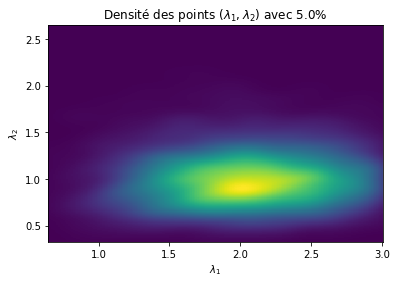

In [14]:
plot(df_simulations, 0.05)

Export PDF : img/1_ABC/05.pdf



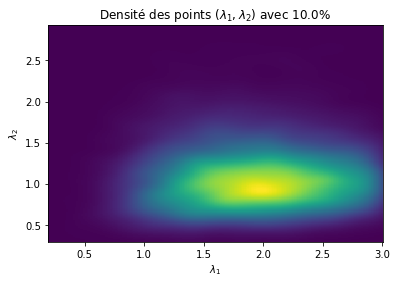

In [15]:
plot(df_simulations, 0.1)

Le résultat de cette simulation est clairement attendu, c'est le cas d'une selection bien trop permissive et notre distribution a priori est normale entre 0 et 3.

Il peut être interessant d'appliquer des mesures en construction différentes. Calculons simplement une médiane sur la différence entre la date de fin de service d'un client et du client précédent.

In [16]:
from statistics import median

def dist1a1(x,y):
    if len(x) == 1:
        X1 = x[0]
    else:
        X1 = median([x[i+1]-x[i] for i in range(len(x)-1)]) 
    if len(y) ==1:
        Y1 = y[0]
    else:
        Y1 = median([y[i+1]-y[i] for i in range(len(y)-1)])
    return abs(X1-Y1)

x = [1, 5, 6]
y = [1, 2, 3]
dist1a1(x,y)

1.5

Recodons rapidement la fonction ABC en ajoutant cette distance "1 à 1".

In [17]:
def ABC_evaluation_1a1(liste_observee, N = 100000, eps = 0.1 , mu1 = 3, mu2 = 3):
    
    #Génération des distributions des lambdas
    L_lambda1 = [np.random.uniform(0,mu1) for i in range(N)]
    L_lambda2 = [np.random.uniform(0,mu2) for i in range(N)]
    
    #Liste des simulations sous forme de DataFrame et la liste des distances associées
    L_sim = []
    L_dist = []
    for i in trange(N):
        
        #Simulation
        data = file_attente(L_lambda1[i], L_lambda2[i], 10)
        liste_dates = list(data["Date fin service"])
        #Ajout de la liste des dates dans L_Sim et de la distance dans L_dist
        L_sim.append(liste_dates)
        L_dist.append(dist1a1(liste_observee,liste_dates))
        
    df_simulations = pd.DataFrame({'Listes Dates': L_sim, 'Distance': L_dist, 'Lambda1': L_lambda1, 'Lambda2': L_lambda2})
    df_simulations.sort_values(by="Distance", inplace=True)
    return df_simulations

Appliquons à présent cette nouvelle méthode avec les mêmes données que précédemment.

  0%|          | 0/100000 [00:00<?, ?it/s]

Export PDF : img/1_ABC/06.pdf



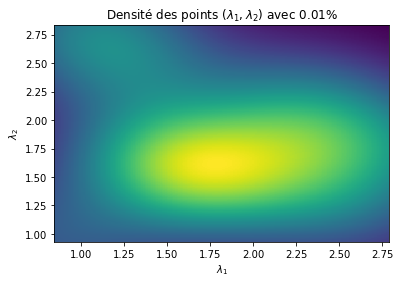

In [18]:
df_simulations = ABC_evaluation_1a1(liste_observee)

plot(df_simulations, 0.0001)

Export PDF : img/1_ABC/07.pdf



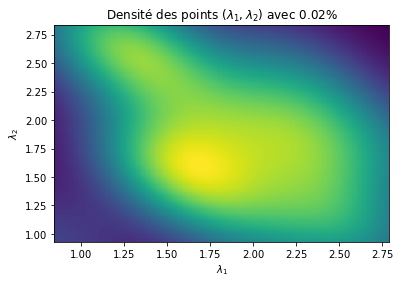

In [19]:
plot(df_simulations, 0.0002)

Export PDF : img/1_ABC/08.pdf



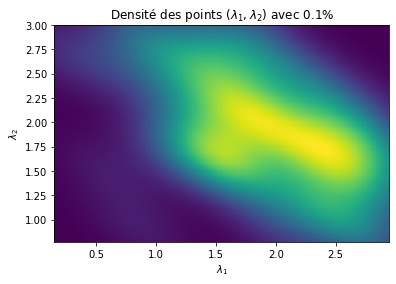

In [20]:
plot(df_simulations, 0.001)

Export PDF : img/1_ABC/09.pdf



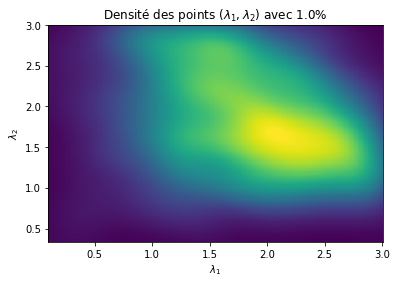

In [21]:
plot(df_simulations, 0.01)

Export PDF : img/1_ABC/10.pdf



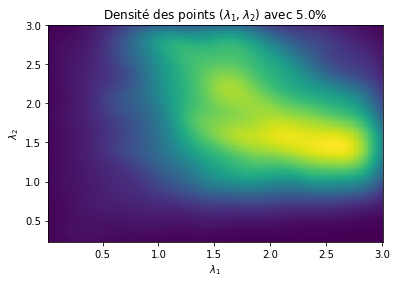

In [22]:
plot(df_simulations, 0.05)

Export PDF : img/1_ABC/11.pdf



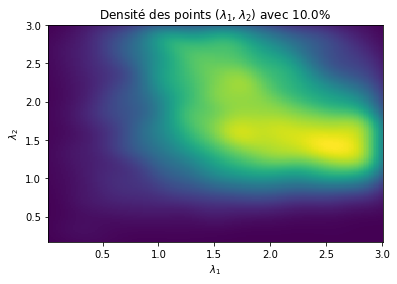

In [23]:
plot(df_simulations, 0.1)

In [24]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 00:03:30
